Fresh start for developing the match_and_detrend routine

I am just storing this here for the later docs to come, when I have produced the cloud trend files


In [1]:
# !mamba install "xarrayutils>=1.0.0" -y
# ! pip install ../cmip6_preprocessing/

In [2]:
import rechunker
rechunker.__version__

'0.4'

In [3]:
import cmip6_preprocessing
print(cmip6_preprocessing.__version__)
print(cmip6_preprocessing.__path__)

0.4.1.dev2+g2c104ea.d20210701
['/home/jovyan/cmip6_preprocessing/cmip6_preprocessing']


In [4]:
import xarrayutils
xarrayutils.__version__

'v1.0.0'

In [18]:
# load two different models
from cmip6_preprocessing.utils import google_cmip_col, cmip6_dataset_id
from cmip6_preprocessing.preprocessing import combined_preprocessing
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [67]:
from dask_gateway import GatewayCluster
from distributed import Client

cluster = GatewayCluster()
cluster.scale(30)
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.3047429259b741ac8727d15ceee327d3 Dashboard: /services/dask-gateway/clusters/staging.3047429259b741ac8727d15ceee327d3/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [68]:
cluster

## Some examples

In [8]:
col = google_cmip_col()
cat = col.search(
    source_id=["CanESM5-CanOE", "GFDL-ESM4"],
    variable_id="thetao",
    grid_label="gn",
)

In [25]:
kwargs = {'preprocess':combined_preprocessing, 'zarr_kwargs':{"use_cftime": True, "consolidated": True}, 'aggregate':False}

ddict_historical = cat.search(experiment_id="historical").to_dataset_dict(**kwargs)
ddict_control = cat.search(experiment_id="piControl").to_dataset_dict(**kwargs)
ddict_ssp585 = cat.search(experiment_id="ssp585").to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## save out some dummy data, since the calculating the trend is not really the main stuff here

In [12]:
from cmip6_preprocessing.postprocessing import combine_datasets, _match_datasets
from cmip6_preprocessing.drift_removal import calculate_drift


def drift_func(ds_list):
    print(ds_list)


# write it out explicitly

trends = {}

for name, ds in ddict_historical.items():
    # get potential matches

    rough_match = _match_datasets(
        ds,
        ddict_control,
        match_attrs=["source_id", "grid_label", "variable_id", "table_id"],
        pop=False,
    )

    # match parent attributes
    exact_match = []
    match_attrs_parent = ["variant_label", "source_id", "experiment_id"]
    for ds_match in rough_match:
        if all(
            [
                ds.attrs["parent_" + ma] == ds_match.attrs[ma]
                for ma in match_attrs_parent
            ]
        ):
            exact_match.append(ds_match)
    if len(exact_match) == 0:
        print("Did not find a match for ...")
    elif len(exact_match) > 1:
        raise RuntimeError(
            "This should not happen. Found more than one matching control run."
        )
    else:
        ds_parent = exact_match[0]

    trends[cmip6_dataset_id(ds)] = calculate_drift(
        ds_parent, ds, ds.attrs["variable_id"]
    )

In [14]:
# I dont actually want to compute these. Lets just replace with a random trend

In [17]:
ds = trends['CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.gn.v20190429']


<xarray.Dataset>
Dimensions:           (bnds: 2, lev: 45, x: 360, y: 291)
Coordinates:
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 284 285 286 287 288 289 290
  * lev               (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    trend_time_range  (bnds) <U19 '5550-01-16 12:00:00' '5799-12-16 12:00:00'
Dimensions without coordinates: bnds
Data variables:
    thetao            (lev, y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes: (12/58)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variant_label:               r1i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/05f0fb20-3395-4112-af53-d1b9241...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...

In [82]:
trends = {k:xr.ones_like(ds)* np.random.rand()/500 for k,ds in trends.items()}

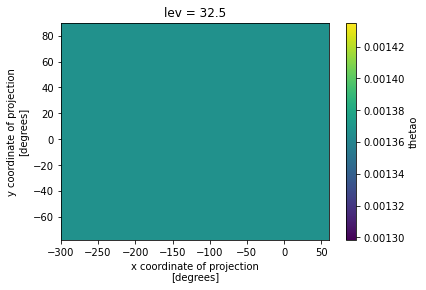

In [83]:
trends['CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gn.none'].thetao.isel(lev=3).plot()

In [84]:
trends['CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.gn.v20190429']

<xarray.Dataset>
Dimensions:           (bnds: 2, lev: 45, x: 360, y: 291)
Coordinates:
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 284 285 286 287 288 289 290
  * lev               (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    trend_time_range  (bnds) <U19 '5550-01-16 12:00:00' '5799-12-16 12:00:00'
Dimensions without coordinates: bnds
Data variables:
    thetao            (lev, y, x) float64 dask.array<chunksize=(45, 291, 360), meta=np.ndarray>
Attributes: (12/59)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/05f0fb20-3395-4112-af53-d1b9241...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...
    original_key:                CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...

## Dev: match_and_detrend

In [85]:
## Develop match_and_detrend
from cmip6_preprocessing.postprocessing import _match_datasets, exact_attrs
from cmip6_preprocessing.drift_removal import remove_trend

def match_and_detrend(ddict, trend_ddict, ref_date='1850', **detrend_kwargs):
    ddict_detrended = {}
    match_attrs = [ma for ma in exact_attrs if ma not in ['experiment_id']] + ['variable_id']
    
    for k, ds in ddict.items():
        trend_ds = _match_datasets(ds, trend_ddict, match_attrs, pop=False)
        
        if len(trend_ds) > 2:
            print(trend_ds)
            raise RuntimeError('This should not find more than one match. Check input')
        elif len(trend_ds) < 2:
            print(f'Could not match {cmip6_dataset_id(ds)}')
        else:
            trend_ds = trend_ds[1] # this is a bit clunky. _match_datasest does return the input ds, so we have to grab the second one?
            # I guess I could pass *trend_ds, but that is not very readable
            variable = ds.attrs['variable_id']
            da_detrended = ds.assign({variable:remove_trend(ds, trend_ds, variable, ref_date=ref_date, **detrend_kwargs)})
            # should this just return a dataset instead?
            ddict_detrended[k] = da_detrended

    return ddict_detrended

In [86]:
ddict_historical_detrended = match_and_detrend(ddict_historical, trends, check_mask=False)
ddict_ssp585_detrended = match_and_detrend(ddict_ssp585, trends, check_mask=False)

In [91]:
from cmip6_preprocessing.postprocessing import combine_datasets

In [95]:
# we need a concat experiments wrapper
def combine_func(ds_list):
    return xr.concat(ds_list, dim="time")


ddict_full = combine_datasets(
    {**ddict_historical, **ddict_ssp585},
    combine_func,
    match_attrs=["source_id", "grid_label", "variable_id", "table_id", "variant_label"],
)

ddict_full_detrended = combine_datasets(
    {**ddict_historical_detrended, **ddict_ssp585_detrended},
    combine_func,
    match_attrs=["source_id", "grid_label", "variable_id", "table_id", "variant_label"],
)

In [99]:
ds.reset_coords(drop=True)

<xarray.Dataset>
Dimensions:  (bnds: 2, lev: 45, x: 360, y: 291)
Coordinates:
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * y        (y) int32 0 1 2 3 4 5 6 7 8 ... 282 283 284 285 286 287 288 289 290
  * lev      (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
Dimensions without coordinates: bnds
Data variables:
    thetao   (lev, y, x) float64 dask.array<chunksize=(45, 291, 360), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variant_label:               r1i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/05f0fb20-3395-4112-af53-d1b9241...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...

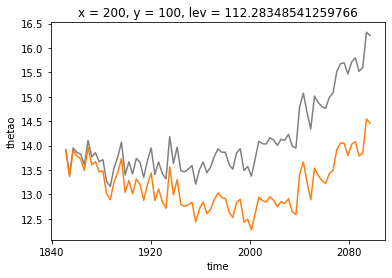

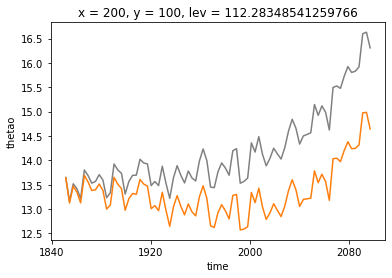

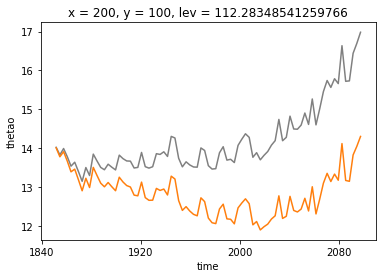

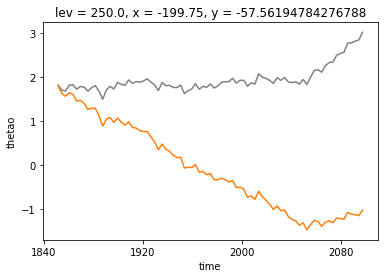

In [102]:
# check a random timeseries for a constitent trend removal
import matplotlib.pyplot as plt

def quick_prep(ds):
    ds = ds.reset_coords(drop=True).isel(**roi).coarsen(time=12*5, boundary='trim').mean()
    return ds

roi = {'x':200, 'y':100, 'lev':10}
for k in ddict_full_detrended.keys():
    ds = quick_prep(ddict_full[k])
    ds_detrended = quick_prep(ddict_full_detrended[k])
    
    plt.figure()
    ds.thetao.plot(color='0.5')
    ds_detrended.thetao.plot(color='C1')
    
    plt.show()